[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\p-mar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\p-mar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\p-mar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\p-mar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


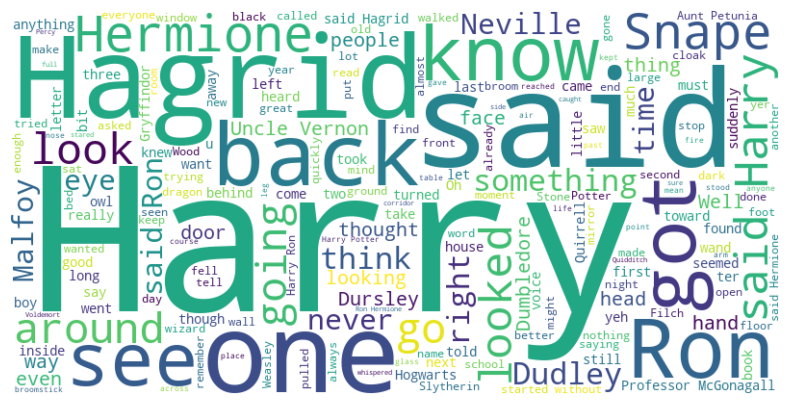

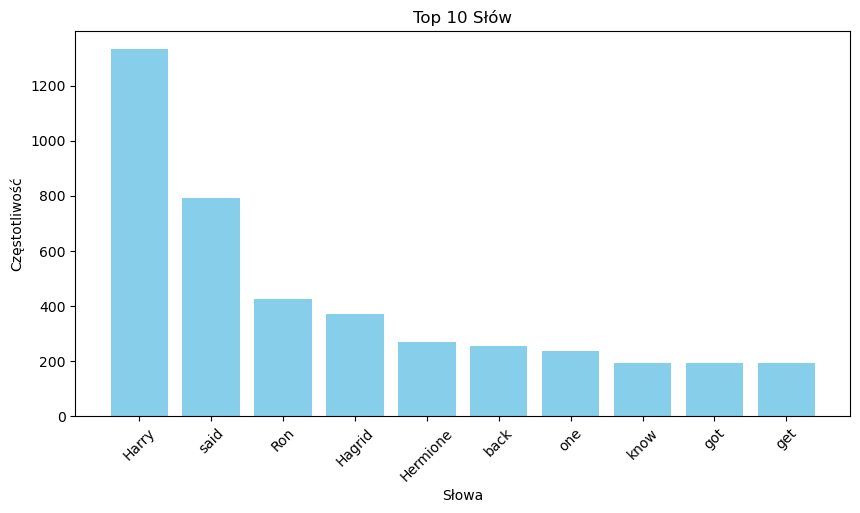

In [8]:
# 1) Top 10 reprezentacji słów (tworzenie np. "bow") - wykres
# 2) Chmurę słów w postaci top_n słów - wykres
# 3) Analiza emocji / wydźwięku - wykres
# 4) Analiza 3 tematów ze zbioru słów lub inna analiza - wykres

import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk import pos_tag
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import numpy as np


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

folder_path = 'data/*.txt'
text_files = glob.glob(folder_path)
                      

if text_files:
    first_text_file = text_files[0]
    
    with open(first_text_file, 'r', encoding='utf-8') as file:
        text_data = file.read()
else:
    print("No text files found in the folder.")
    

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Podziel tekst na słowa
words = word_tokenize(text_data, language='english')

# Usuń stopwords i zastosuj lematyzację
filtered_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words and word.isalpha()]

# Połącz słowa z powrotem w jeden tekst
filtered_text = ' '.join(filtered_words)

# Utwórz obiekt WordCloud
#TODO ułożyć wordcloud w jakiś kształt 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Wyświetl chmurę słów
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

word_counts = Counter(filtered_words)
top_10_words = word_counts.most_common(10)
words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Słowa')
plt.ylabel('Częstotliwość')
plt.title('Top 10 Słów')
plt.xticks(rotation=45)
plt.show()

<class 'list'>
<class 'textblob.blob.Sentence'>
M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.
4869


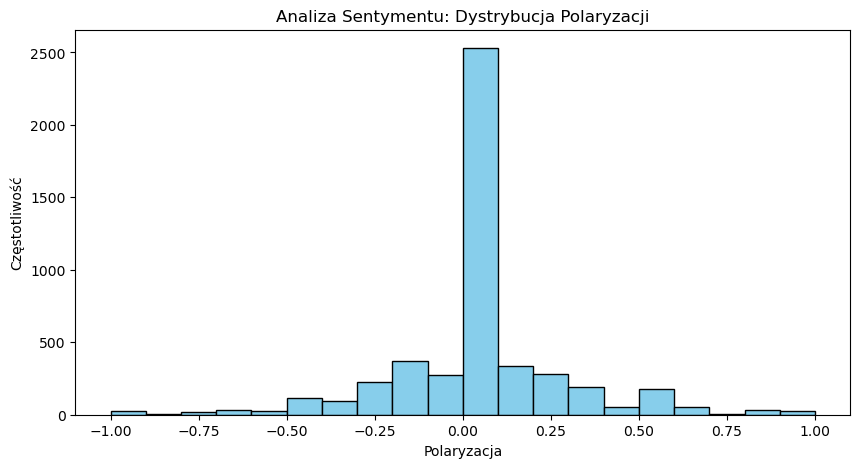

Średnia Polaryzacja: 0.029664395980051796
Średnia Subiektywność: 0.3129185371717806


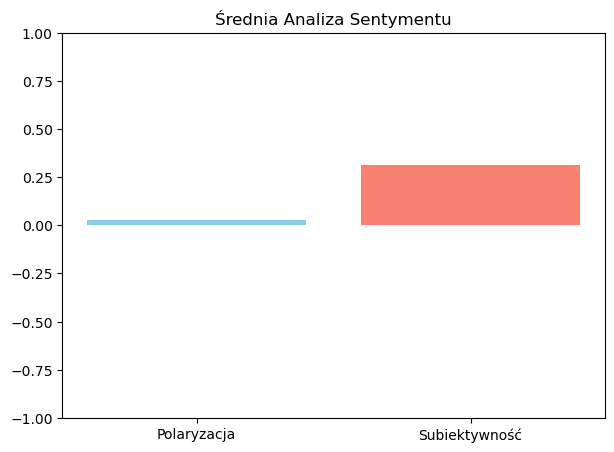

Podsumowanie wyników:
Średnia Polaryzacja: 0.029664395980051796 - Tekst jest generalnie neutralny z lekką tendencją do pozytywności.
Średnia Subiektywność: 0.3129185371717806 - Tekst zawiera umiarkowaną ilość subiektywnych opinii.


In [6]:
# Przetwarzanie tekstu za pomocą TextBlob
blob = TextBlob(text_data)
sentences = blob.sentences

print(type(sentences))
print(type(sentences[0]))
print(sentences[0])
print(len(sentences))

# Analiza sentymentu dla każdego zdania
polarities = [sentence.sentiment.polarity for sentence in sentences]

# Wyświetlenie histogramu dystrybucji polaryzacji
plt.figure(figsize=(10, 5))
plt.hist(polarities, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Polaryzacja')
plt.ylabel('Częstotliwość')
plt.title('Analiza Sentymentu: Dystrybucja Polaryzacji')
plt.show()

# Obliczenie średniej polaryzacji i subiektywności dla całego tekstu
avg_polarity = sum(polarities) / len(polarities)
subjectivity = [sentence.sentiment.subjectivity for sentence in sentences]
avg_subjectivity = sum(subjectivity) / len(subjectivity)

# Wyświetlenie wyników średniej polaryzacji i subiektywności
print(f'Średnia Polaryzacja: {avg_polarity}')
print(f'Średnia Subiektywność: {avg_subjectivity}')

# Wykres średniej polaryzacji i subiektywności
etykiety = ['Polaryzacja', 'Subiektywność']
wartości = [avg_polarity, avg_subjectivity]

plt.figure(figsize=(7, 5))
plt.bar(etykiety, wartości, color=['skyblue', 'salmon'])
plt.ylim(-1, 1)
plt.title('Średnia Analiza Sentymentu')
plt.show()

print("Podsumowanie wyników:")
print(f'Średnia Polaryzacja: {avg_polarity} - Tekst jest generalnie neutralny z lekką tendencją do pozytywności.')
print(f'Średnia Subiektywność: {avg_subjectivity} - Tekst zawiera umiarkowaną ilość subiektywnych opinii.')

C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


4869


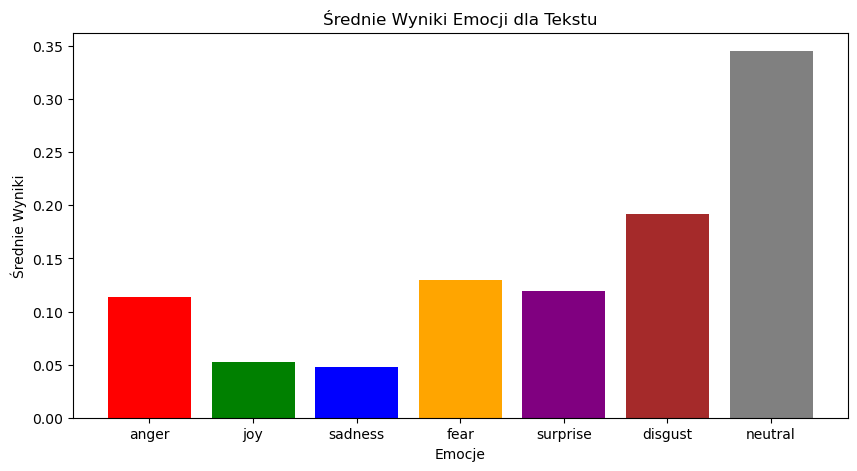

In [7]:
import torch 
from transformers import pipeline 
import re

# Inicjalizacja klasyfikatora do analizy emocji
classifier = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', return_all_scores=True)
emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'neutral']  # Lista emocji
results = []

# Analiza emocji dla każdej sentencji
for sentence in sentences:
    if sentence.strip():
        result = classifier(sentence.string.strip())[0]
        results.append({res['label']: res['score'] for res in result})

# Zliczanie sumarycznych wyników dla każdej emocji
emotion_scores = {emotion: 0 for emotion in emotions}
for result in results:
    for emotion in result:
        emotion_scores[emotion.lower()] += result[emotion]

# Obliczenie średnich wyników emocji
total_sentences = len(sentences)
emotion_scores = {emotion: score / total_sentences for emotion, score in emotion_scores.items()}

print(total_sentences)

import matplotlib.pyplot as plt

# Przygotowanie danych do wykresu
labels = list(emotion_scores.keys())
values = list(emotion_scores.values())

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color=['red', 'green', 'blue', 'orange', 'purple', 'brown', 'grey'])
plt.xlabel('Emocje')
plt.ylabel('Średnie Wyniki')
plt.title('Średnie Wyniki Emocji dla Tekstu')
plt.show()


In [4]:
#Sprawdzanie 5 zdań z podanej kategorii
category = 'anger'
category_scores = [(sentence.strip(), result[category]) for sentence, result in zip(sentences, results) if category in result]

# Sortowanie zdań według wyniku emocji "disgust"
category_scores = sorted(category_scores, key=lambda x: x[1], reverse=True)

# Wyświetlenie przykładowych zdań z najwyższymi wynikami dla "disgust"
print(f"Top sentences with highest {category} scores:")
for sentence, score in category_scores[:5]:  # Możesz zmienić liczbę wyświetlanych zdań
    print(f"Sentence: {sentence}\n{category} Score: {score}\n")

Top sentences with highest anger scores:
Sentence: How dare you tell such lies!
anger Score: 0.9878706336021423

Sentence: A roar of rage echoed from the Gryffindors below — Marcus Flint had blocked Harry on purpose, and Harry’s broom spun off course, Harry holding on for dear life.
anger Score: 0.9846867918968201

Sentence: “What on earth were you thinking of?” said Professor McGonagall, with cold fury in her voice.
anger Score: 0.9833954572677612

Sentence: Harry and Dudley promptly had a furious but silent fight over who would listen at the keyhole; Dudley won, so Harry, his glasses dangling from one ear, lay flat on his stomach to listen at the crack between door and floor.
anger Score: 0.9708712100982666

Sentence: “Where was I?” said Hagrid, but at that moment, Uncle Vernon, still ashen-faced but looking very angry, moved into the firelight.
anger Score: 0.9681202173233032



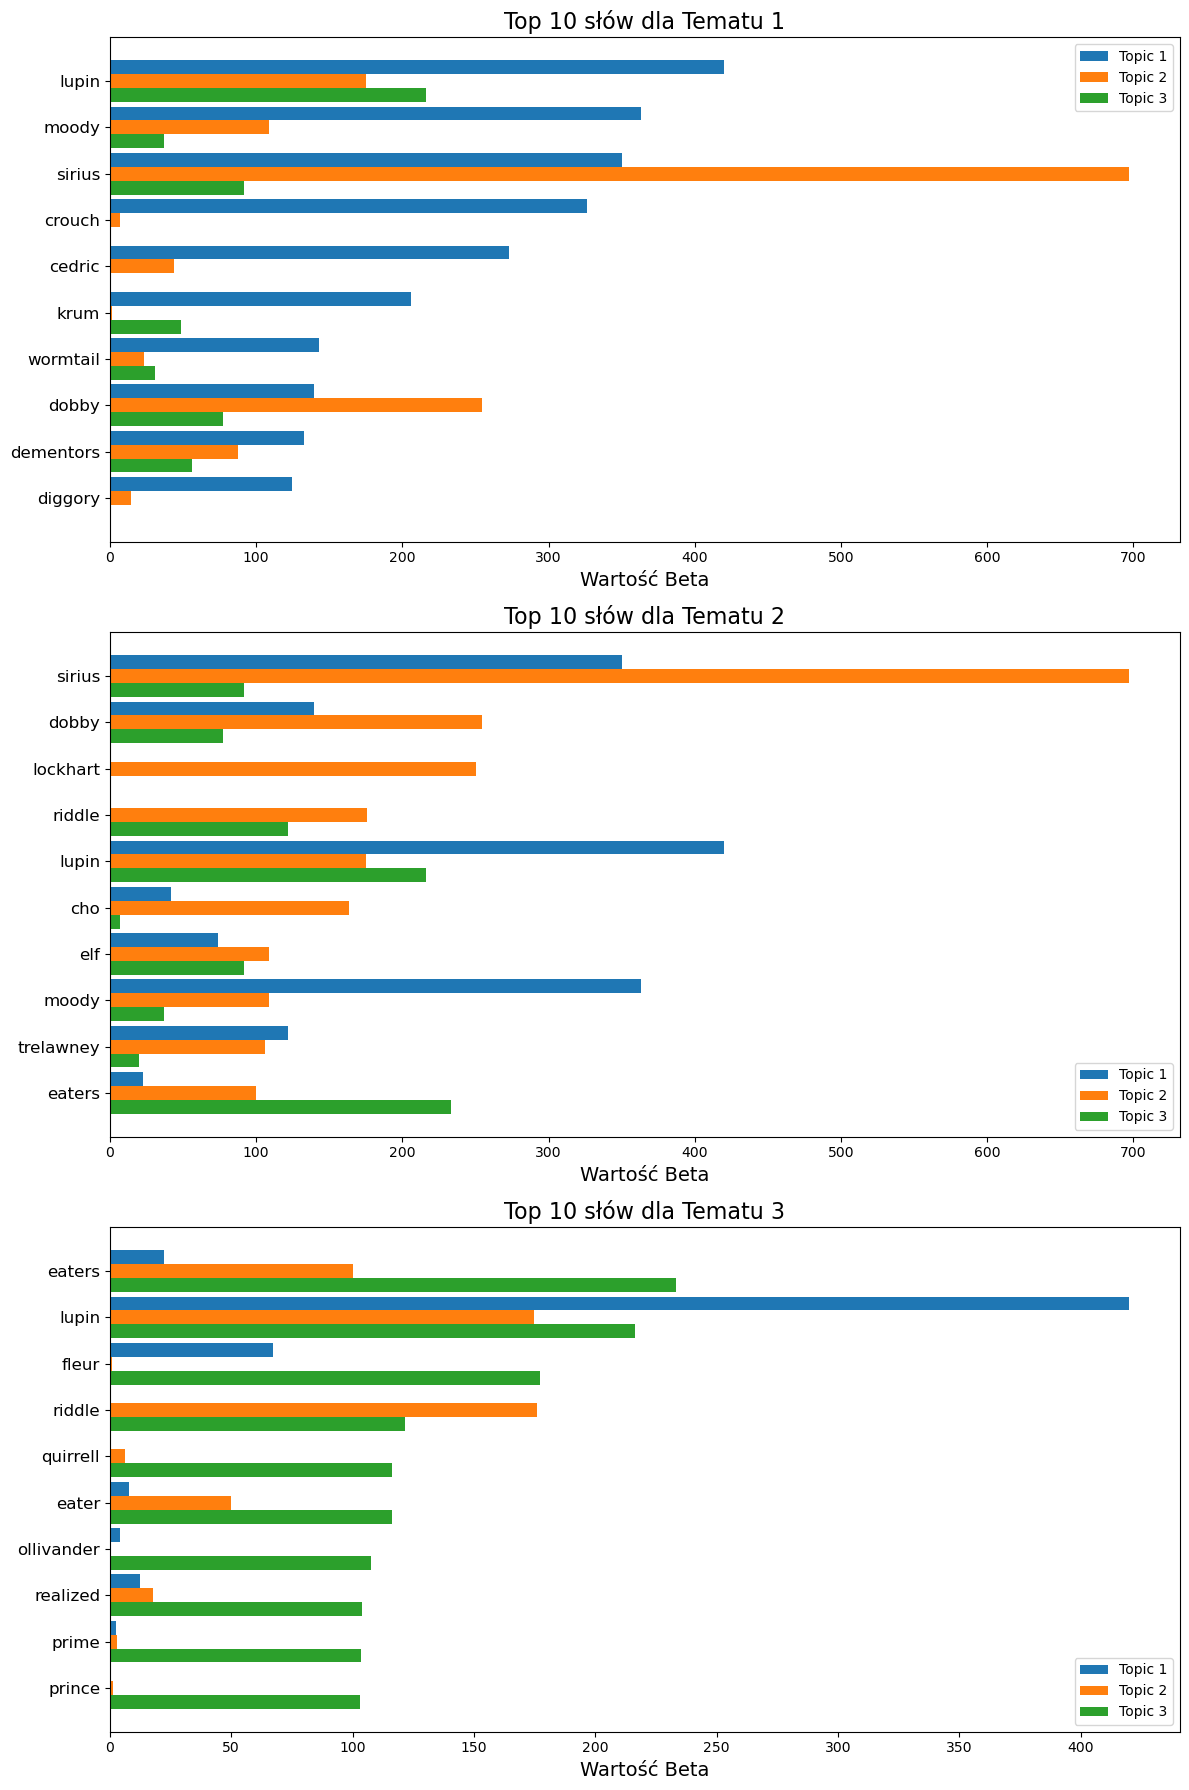

In [5]:
documents = [open(file_path, 'r', encoding='utf-8').read() for file_path in text_files]

# Tworzenie macierzy dokument-term
vectorizer = CountVectorizer(max_df=0.95, min_df=4, stop_words='english')
X = vectorizer.fit_transform(documents)

# Użycie modelu LDA do analizy tematycznej
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Aktualizacja funkcji get_top_words
def get_top_words(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    top_words_beta = []
    for topic_idx, topic in enumerate(model.components_):
        top_idx = np.argsort(topic)[::-1][:n_words]
        top_words = [words[i] for i in top_idx]
        top_beta_values = topic[top_idx]
        
        # Pobranie beta wartości dla innych tematów dla top 10 słów
        all_beta_values = model.components_[:, top_idx]
        
        top_words_beta.append({
            'topic': topic_idx + 1,
            'words': top_words,
            'beta_values': top_beta_values,
            'all_beta_values': all_beta_values
        })
    return top_words_beta

# Pobranie słów z największym współczynnikiem beta dla każdego tematu
top_words_beta = get_top_words(lda, vectorizer, n_words=10)

# Tworzenie wykresów słupkowych dla każdego tematu
fig, axes = plt.subplots(len(top_words_beta), 1, figsize=(12, 6 * len(top_words_beta)))

bar_width = 0.3

for ax, topic in zip(axes, top_words_beta):
    x = np.arange(len(topic['words']))
    
    for i, beta_values in enumerate(topic['all_beta_values']):
        ax.barh(x + i * bar_width, beta_values, bar_width, align='center', label=f'Topic {i + 1}')
    
    ax.set_yticks(x + bar_width / 2 * (len(topic['all_beta_values']) - 1))
    ax.set_yticklabels(topic['words'], fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Wartość Beta', fontsize=14)
    ax.set_title(f'Top 10 słów dla Tematu {topic["topic"]}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()
